# Hate Speech Classifier

## Import libraries
Along the project we will use different libraries to: load the data from a CSV files (pandas), preprocess the data (re, string, nltk), create the training and test datasets (sklearn) and of course TensorFlow for all Machine Learning modeling

In [1]:
import re
import numpy
import string
import pandas as pd
import tensorflow as tf
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras import losses
from nltk.tokenize import TweetTokenizer
from tensorflow.keras import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

print(tf.__version__) #Make sure to use the latest TensorFlow verion (nightly)

2.3.0


## Custom Functions
Here we will define custom functions used along the project to plot, preprocess the data and vectorize it

In [2]:
def plot_graphs(history, metric):
    """Plot metrics against epochs """
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+ metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+ metric])
    plt.show()

In [3]:
tweet_tokenizer = TweetTokenizer()

def remove_username(tweet):
    """Replaces tweeter usernames for standard names 
    
    # Arguments
        input_data: tweet to clean.
    """
    tokenized_tweet = tweet_tokenizer.tokenize(tweet) #Tokenize the tweet preserving the @ symbol
    count = 0
    sub_counter = 0
    for word in tokenized_tweet:
        if (re.match('^@.*', word) != None): #Matches any username
            sub_counter = sub_counter + 1
            tokenized_tweet[count] = re.sub('^@.*', '@Subject' + str(sub_counter), word)
        count = count + 1
    return " ".join(tokenized_tweet)

In [4]:
def custom_standardization(input_data):
    """Clean and transform input data to lowercase
    
    # Arguments
        input_data: tweet to clean.
    """
    lowercase = tf.strings.lower(input_data)
    remove_colors = tf.strings.regex_replace(lowercase, '&#\d+;', '')
    remove_hex = tf.strings.regex_replace(remove_colors, r'[^\x00-\x7f]', r'')
    remove_url = tf.strings.regex_replace(remove_hex, 'http.+$', '')
    remove_puntuation = tf.strings.regex_replace(remove_url, '[%s]' % re.escape(string.punctuation), '')
    remove_amp = tf.strings.regex_replace(remove_url, '&amp;', '')
    return tf.strings.regex_replace(remove_amp, 'http.+$', '')

In [5]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

### Define layers
Here we define the a TextVectorization layer that will allow us to convert strings into vectors, using a vocabulary. We also define the function that will allow us to vectorize our dataset.

We define a vocabulary size of 10000 as it had better performance than 15000 and 5000. 
The vector size of 40 is based on the longest tweet in the dataset.

In [6]:
VOCABULARY_SIZE = 10000 #Number of vocabulary words (manually chosen)
VECTOR_SEQ_SIZE = 40 #Max length of the vector (manually chosen)

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=VOCABULARY_SIZE,
    output_mode='int',
    output_sequence_length=VECTOR_SEQ_SIZE)

In [7]:
def vectorize_text(text, label):
    """Vectorize a define (text, label) dataset """
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

## Generate Dataset
In order to create our classifier, we need to create a dataset that can be processed by TensorFlow. First, let's define the path of our input file

In [8]:
CSV_FILE = "./hate_speech_dataset_sample_complete.csv" # Path of our CSV file containing the dataset
LABEL_COLUMN = 'class' # This is the name of the column within the CSV file used as label
SELECTED_COLUMNS = ['class','tweet'] #All other columns can be ignored

The current dataset provided by a CSV file has more that one category, this is because it makes separation between:
* Hate speech/aggresive language
* Non-aggressive language

In [9]:
full_df = pd.read_csv(CSV_FILE, sep=';')
df = full_df[SELECTED_COLUMNS]

df.loc[:, 'tweet'] = df.loc[:, 'tweet'].apply(lambda x: remove_username(x)) #Remove usernames and improve anonimity

### Inspect the dataset
Let see some useful information about the data that we will use to train the model

In [10]:
num_characters = [len(s) for s in df['tweet']]
print("Maximum number of characters BEFORE cleaning the data: " + str(numpy.max(num_characters)))

max_tweets = numpy.where(num_characters == numpy.max(num_characters))
print("Length of longest tweet " + str(df.loc[max_tweets[0][0],'tweet']))

# print("Average number of characters BEFORE cleaning the data : " + str(numpy.mean(num_characters)))

Maximum number of characters BEFORE cleaning the data: 183
Length of longest tweet ★ @Subject1 ★ @Subject2 ★ @Subject3 ★ @Subject4 ★ GRAND OPENING ! ★ @Subject5 ★ @Subject6 ★ @Subject7 ★ @Subject8 ★ TOP CLASS ★ Oriental Massage ★ PERFECT ! ★ / http://t.co/4Hhxk9MKHe


Let's check the number of characters and calculate the number of samples / number of words per sample, this metric is useful if when deciding which model to use. Ideally a number > than 1500 suggest to use a Sequence model instead of n-grams

In [11]:
num_words = [len(s.split()) for s in df['tweet']]
print("Average number of words in a sample: " + str(numpy.mean(num_words)))

print("number of samples / number of words per sample: " + str(len(df['tweet']) / numpy.mean(num_words)))

Average number of words in a sample: 15.898469988230678
number of samples / number of words per sample: 2404.948402475497


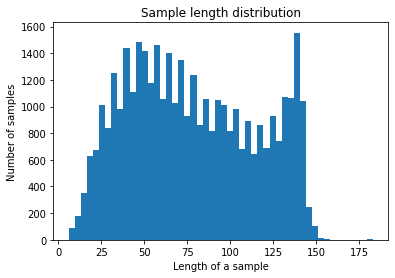

In [12]:
plot_sample_length_distribution(df['tweet'])

Now we split the dataframe between training and test

In [13]:
train_df, test_df = train_test_split(df, test_size=0.2)
print(len(train_df), 'train examples')
print(len(test_df), 'test examples')

30588 train examples
7647 test examples


Now we need to create a TensorFlow dataset using our cleaned dataframe. The next step is to define a batch size. We train the model using these batches. We will use a size of 256 as it has the best performance compared with 64 and 128. Going into bigger batches caused problems when trying to use different number of epochs (this is because we run out of data)

In [14]:
BATCH_SIZE = 256
train_ds = tf.data.Dataset.from_tensor_slices((train_df['tweet'].values, train_df['class'].values))
train_ds = train_ds.batch(BATCH_SIZE)

Let's see how our data looks like and do the same for the test dataset

In [15]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b"@Subject1 I highly doubt you're a real woman . You're prolly a fat ass man . Who fuckin cares ? ! ? Let me do me ho"
Label 0
Review b"Want to go get this brownie , I'm stuck doe ."
Label 1
Review b'RT @Subject1 : @Subject2 is the realest bitch I know . Lol'
Label 0


In [16]:
test_ds = tf.data.Dataset.from_tensor_slices((test_df['tweet'].values, test_df['class'].values))
test_ds = test_ds.batch(BATCH_SIZE)

## Preprocess the data
Now that the file is loaded in the dataset, we need to pre-process the data using all our previous set up.

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [18]:
# Vectorize the train and test datasets
train_vectorized_ds = train_ds.map(vectorize_text)
test_vectorized_ds = test_ds.map(vectorize_text)

Before building and compiling the model, it is worthy to take a look to the content of `the train_vectorized_ds` variable.

In [19]:
first_batch = train_vectorized_ds.take(1).as_numpy_iterator() # A single batch is made of 32 tweets with 32 labels
print(train_vectorized_ds)
first_tweet = next(first_batch)[0][0] # Get first combination of tweet, label and then get first tweet alone
print(first_tweet)

<MapDataset shapes: ((None, 40), (None,)), types: (tf.int64, tf.int64)>
[   2    4 2256 1588  114    5  176  535    3  114  971    5  355   62
  136    3  104  337 1485   20    6   20  174   27   63   27  362    0
    0    0    0    0    0    0    0    0    0    0    0    0]


Checking the format that will be used to train our model give us some insights on:
* The format in which we should provide texts to make predictions
* How much padding should we use

## Build the model
We will create a sequential model that starts with "an embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors" []. Then we define "a recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next".

"The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies."

In [32]:
class CustomInnerModel(tf.keras.Model):
    def __init__(self, vectorize_layer):
        super(CustomInnerModel, self).__init__()
        self.inner_layers = [
            tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()), 64),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
        ]

    def call(self, inputs):
        x = inputs
        for layer in self.inner_layers:
            x = layer(x)
        return x
    
model = tf.keras.Sequential(CustomInnerModel(vectorize_layer))

## Compile the model

In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model
Here we need to define the number of epochs, during each epoch the model goes through the whole dataset. If we use too many epochs we take the risk to overfit the model. Here I tested with 5, 8 and 13. 8 has the best performance.

In [34]:
history = model.fit(train_vectorized_ds, epochs=1,
                    validation_data=test_vectorized_ds, 
                    validation_steps=1)

120/120 [==============================] - 23s 191ms/step - loss: 0.6734 - accuracy: 0.4724 - val_loss: 0.6051 - val_accuracy: 0.5352


### Calculate loss and accuracy
Let's see how well the model is performing

In [35]:
test_loss, test_acc = model.evaluate(test_vectorized_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

30/30 [==============================] - 2s 63ms/step - loss: 0.6105 - accuracy: 0.5793
Test Loss: 0.610486626625061
Test Accuracy: 0.5793121457099915


## Plot accuracy and loss

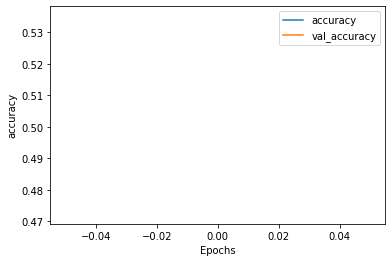

In [36]:
plot_graphs(history, 'accuracy')

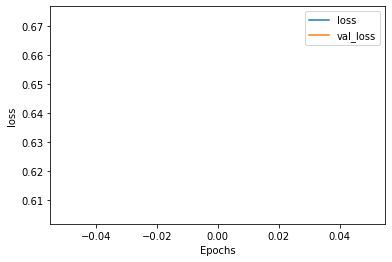

In [37]:
plot_graphs(history, 'loss')

# Make a Prediction

Now we can try to predict more Tweets now that our model is complete. In order to do this we need to encode the tweet, after that any value >= 0.5 would mean that the tweet is not agressive language.

In [38]:
sample_pred_text = ('Nigger hoe This is a test, even if I add some bad words here, they might not be considered aggresive language',
                   'You will die with so much fun!',
                    'You should die and go to hell, I hate people like you!',
                   'We need to get rid of people like that they are trash',
                   'Niggers people should be killed')

vectorized_sample = vectorize_text(sample_pred_text, 0) # Here we add a 0 class value just because the `vectorize_text` function requires 2 parameters

In [28]:
predictions = export_model.predict(sample_pred_text)
print(predictions)

NameError: name 'export_model' is not defined

## Save the model
Let's save the model before continue, we will deploy this model later in a browser

In [39]:
model.save("my_model")

# Delete the custom-defined model class to ensure that the loader does not have
# access to it.
del CustomInnerModel

loaded = tf.keras.models.load_model("my_model")


INFO:tensorflow:Assets written to: my_model/assets


In [31]:
loaded = tf.keras.models.load_model("my_model")

NameError: name 'input_arr' is not defined

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Ensure that the accuracy is the same
loss, accuracy = export_model.evaluate(test_ds)
print(accuracy)

In [ ]:
export_model.save('./js', save_format='tf')

# Stack one more layer


In [ ]:
model_with_extra_layer = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()), 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model_with_extra_layer.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model_with_extra_layer.fit(train_vectorized_ds, epochs=8,
                    validation_data=test_vectorized_ds, 
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model_with_extra_layer.evaluate(test_vectorized_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

We notice that the effect of another layer is not remarkable. Hence we will proceed with the first model.